<a href="https://colab.research.google.com/github/amadousysada/image-segmentation/blob/main/p8_01_exploration_and_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import des librairies

In [51]:
import time
init_time = time.time()

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import keras

# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- keras        =>: {keras.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")
print(f"{' '*2}- mlflow   =>: {mlflow.__version__}")

Versions:
  - Numpy        =>: 2.0.2
  - tensorflow   =>: 2.18.0
  - keras        =>: 3.8.0
  - keras        =>: 3.8.0
  - matplotlib   =>: 3.10.0
  - mlflow   =>: 2.22.0


In [52]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploration

In [54]:
# Mapping des groupes vers la liste des classes Cityscapes correspondantes
"""
Sources:
  - https://raw.githubusercontent.com/mcordts/cityscapesScripts/master/cityscapesscripts/helpers/labels.py
  - https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
  - https://datasetninja.com/cityscapes
  - https://github.com/mcordts/cityscapesScripts
"""
CLASS_GROUPS = {
    "flat":        ["road", "sidewalk", "parking", "rail track"],
    "human":       ["person", "rider"],
    "vehicle":     ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction":["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object":      ["pole", "pole group", "traffic sign", "traffic light"],
    "nature":      ["vegetation", "terrain"],
    "sky":         ["sky"],
    "void":        ["unlabeled", "ego vehicle", "ground", "rectification border", "out of roi", "dynamic", "static"]
}

GROUP_PALETTE = [
    (128, 64, 128),    # 0 - flat
    (220, 20, 60),     # 1 - human
    (0, 0, 142),       # 2 - vehicle
    (70, 70, 70),      # 3 - construction
    (220, 220, 0),     # 4 - object
    (107, 142, 35),    # 5 - nature
    (70, 130, 180),    # 6 - sky
    (0, 0, 0),         # 7 - void
]

group_cmap = ListedColormap(np.array(GROUP_PALETTE) / 255.0)

ordered_groups = list(CLASS_GROUPS.keys())

LABEL_ID_TO_NAME = {
    0: "unlabeled",
    1: "ego vehicle",
    2: "rectification border",
    3: "out of roi",
    4: "static",
    5: "dynamic",
    6: "ground",
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track",
    11: "building",
    12: "wall",
    13: "fence",
    14: "guard rail",
    15: "bridge",
    16: "tunnel",
    17: "pole",
    18: "pole group",
    19: "traffic light",
    20: "traffic sign",
    21: "vegetation",
    22: "terrain",
    23: "sky",
    24: "person",
    25: "rider",
    26: "car",
    27: "truck",
    28: "bus",
    29: "caravan",
    30: "trailer",
    31: "on rails",
    32: "motorcycle",
    33: "bicycle",
}

NAME_TO_LABEL_ID = {v: k for k, v in sorted(LABEL_ID_TO_NAME.items())}

CLASS_MAP = {}
for group_idx, group_name in enumerate(ordered_groups):
    for class_name in CLASS_GROUPS[group_name]:
        cid = NAME_TO_LABEL_ID.get(class_name, -1)
        CLASS_MAP[cid] = group_idx


mapping = [7] * 34   # initialisé à 7 (void)
for orig_id, new_id in CLASS_MAP.items():
    mapping[orig_id] = new_id

In [55]:
tf.constant(mapping, dtype=tf.int32)

<tf.Tensor: shape=(34,), dtype=int32, numpy=
array([7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
       5, 6, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>

In [56]:
def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    return image, mask


def build_dataset(img_paths, mask_paths, image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.3, augment=False, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

  def _load(i, m):
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    mask = tf.gather(tf.constant(mapping, dtype=tf.int32), mask)

    return img, mask

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(buffer_size=1024)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return ds

def make_dataset(image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.0, augment=False, shuffle=False):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  if data_type == "train" and validation_split > 0:
      n = len(images_path)
      split_idx = int((1 - validation_split) * n)
      train_imgs, val_imgs = images_path[:split_idx], images_path[split_idx:]
      train_msks, val_msks = masks_path[:split_idx], masks_path[split_idx:]

      train_ds = build_dataset(train_imgs, train_msks, image_size, batch_size, shuffle=shuffle, augment=augment)
      val_ds   = build_dataset(val_imgs, val_msks, image_size, batch_size)
      return train_ds, val_ds
  else:
      return build_dataset(images_path, masks_path, image_size, batch_size, shuffle=shuffle, augment=augment)

In [57]:
def show_vertical_legend(palette, labels, ax):
    """
    Affiche une légende verticale (groupe/couleur).
    palette : liste de couleurs RGB [(R,G,B), ...]
    labels : liste des noms de groupes (même taille que palette)
    """
    # Créer les patches (légendes)
    patches = [
        mpatches.Patch(color=np.array(rgb)/255.0, label=label)
        for rgb, label in zip(palette, labels)
    ]

    # Afficher la légende verticalement à gauche
    ax.legend(handles=patches, loc='center left', bbox_to_anchor=(0, 0.5),
              frameon=False, fontsize=10)
    ax.axis('off')
    plt.tight_layout()

def plot_sample(ds, figsize=(14, 6), title=""):
  for imgs, masks in ds.take(1):
    idx = np.random.choice(range(0,32))
    img = imgs[idx]
    mask = masks[idx]

    plt.figure(figsize=figsize)
    ax= plt.subplot(1, 4, 1)
    ax.imshow(img)
    plt.title("Image")
    plt.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)
    plt.title("Mask")
    plt.axis("off")

    ax = plt.subplot(1, 4, 3)
    mask_arr = mask.numpy()
    unique_classes, counts = np.unique(mask_arr, return_counts=True)
    percentages = counts / mask_arr.size * 100
    group_names = [ordered_groups[i] for i in unique_classes]

    ax.pie(percentages, labels=group_names, autopct="%1.1f%%", startangle=90, colors=group_cmap.colors, textprops={'color': 'white'})
    ax.axis("equal")
    ax.set_title("Répartition des groupes dans le mask")
    plt.axis("equal")
    plt.suptitle("Test de l'echantillon train", fontsize=16)

    ax = plt.subplot(1, 4, 4)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)
    plt.show()


def display_prediction(image, pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)  # tu peux aussi utiliser une palette custom
    plt.title("Prédiction (groupes)")
    plt.axis("off")

    ax = plt.subplot(1, 3, 3)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)

    plt.show()

In [58]:
%%time
train_ds = make_dataset(data_type="train", batch_size=32, augment=True)
validation_ds = make_dataset(data_type="val", batch_size=32)
test_ds = make_dataset(data_type="test", batch_size=32)

CPU times: user 169 ms, sys: 163 ms, total: 332 ms
Wall time: 886 ms


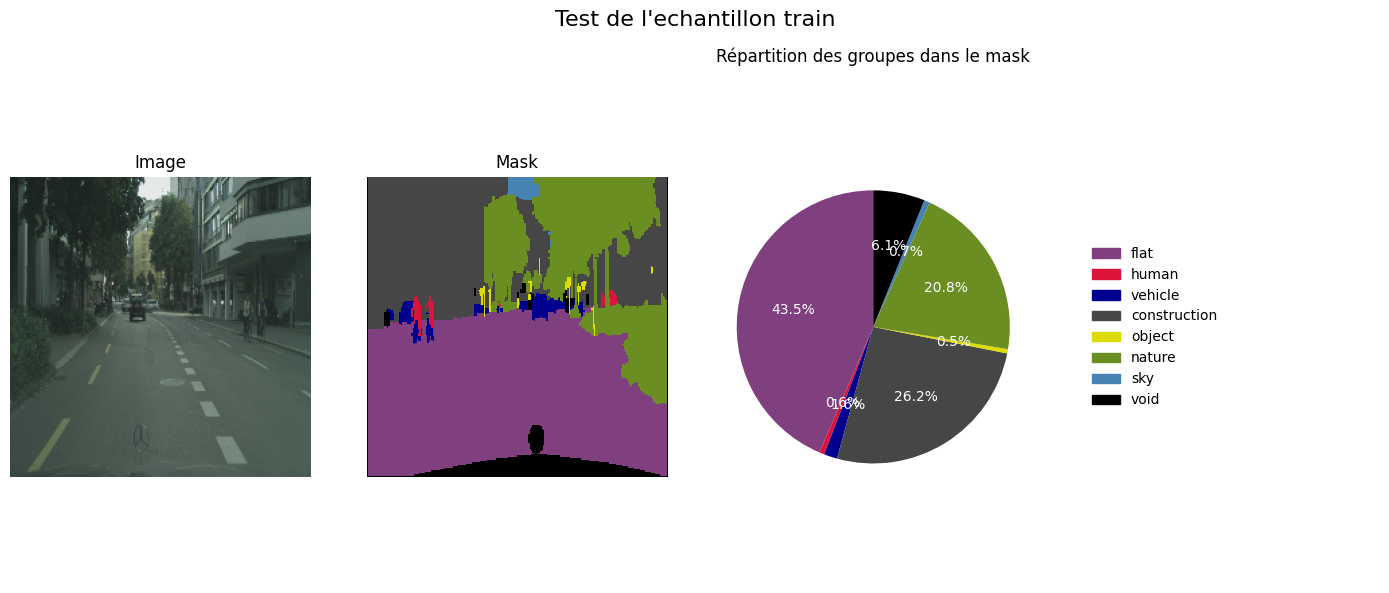

CPU times: user 4.57 s, sys: 90.8 ms, total: 4.66 s
Wall time: 938 ms


In [59]:
%%time
plot_sample(train_ds, title="Test de l'echantillon train")

In [60]:
%%time
plot_sample(validation_ds, title="Test de l'echantillon validation", figsize=(18, 6))

CPU times: user 4.42 s, sys: 68.6 ms, total: 4.49 s
Wall time: 806 ms


AFFICHER LES LABELS par COULEURS

# Modélisation

### Metrics & Loss functions

**Metrcis**:
* MeanIoU
* Accuracy

In [61]:
class MeanIoUArgmax(tf.keras.metrics.MeanIoU):
    """Custom MeanIoU metric that applies argmax to predictions"""
    def __init__(self, num_classes, name="mean_io_u_argmax", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred : (batch, H, W, num_classes) → take the winning class
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)



**Loss functions:**
* Dice Loss
* Focal Loss
* Combined Loss
* balanced_cross_entropy

In [62]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for semantic segmentation

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Convert predictions to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Flatten tensors
    y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
    y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

    # Calculate Dice coefficient for each class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)

    # Return 1 - mean Dice coefficient as loss
    return 1 - tf.reduce_mean(dice_coeff)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for addressing class imbalance

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        alpha: Weighting factor for rare class
        gamma: Focusing parameter

    Returns:
        Focal loss value
    """
    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))

    # Calculate focal weight
    p_t = y_true_one_hot * y_pred
    alpha_t = y_true_one_hot * alpha
    focal_weight = alpha_t * tf.pow(1 - p_t, gamma)

    # Apply focal weight
    focal_loss = focal_weight * ce_loss

    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))


def combined_loss(y_true, y_pred, dice_weight=0.5, ce_weight=0.5):
    """
    Combined Dice + Cross-Entropy Loss

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        dice_weight: Weight for dice loss
        ce_weight: Weight for cross-entropy loss

    Returns:
        Combined loss value
    """
    dice = dice_loss(y_true, y_pred)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    ce = tf.reduce_mean(ce)

    return dice_weight * dice + ce_weight * ce


def balanced_cross_entropy(y_true, y_pred, class_weights=None):
    """
    Balanced Cross-Entropy Loss with class weights

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        class_weights: Optional class weights tensor

    Returns:
        Weighted cross-entropy loss
    """
    if class_weights is None:
        # Default weights for Cityscapes (8 classes)
        class_weights = tf.constant([0.5, 2.0, 2.0, 1.0, 1.5, 3.0, 1.0, 0.1])

    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate weighted cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))
    weighted_ce = ce_loss * class_weights

    return tf.reduce_mean(tf.reduce_sum(weighted_ce, axis=-1))

### Architecture

In [63]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Basic convolutional block with optional batch normalization"""
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


def encoder_block(x, filters, pool_size=2):
    """Encoder block for U-Net: conv + conv + maxpool"""
    skip = conv_block(x, filters)
    skip = conv_block(skip, filters)
    x = layers.MaxPooling2D(pool_size)(skip)
    return x, skip


def decoder_block(x, skip, filters):
    """Decoder block for U-Net: upsample + concat + conv + conv"""
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x


def unet_mini(input_shape=(224, 224, 3), num_classes=8, filters_base=32):
    """
    Mini U-Net model (non-pretrained baseline)

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        filters_base: Base number of filters

    Returns:
        Keras Model
    """
    inputs = layers.Input(input_shape)

    # Encoder
    x1, skip1 = encoder_block(inputs, filters_base)      # 224x224 → 112x112
    x2, skip2 = encoder_block(x1, filters_base * 2)      # 112x112 → 56x56
    x3, skip3 = encoder_block(x2, filters_base * 4)      # 56x56 → 28x28

    # Bottleneck
    bottleneck = conv_block(x3, filters_base * 8)       # 28x28
    bottleneck = conv_block(bottleneck, filters_base * 8)

    # Decoder
    d1 = decoder_block(bottleneck, skip3, filters_base * 4)  # 28x28 → 56x56
    d2 = decoder_block(d1, skip2, filters_base * 2)          # 56x56 → 112x112
    d3 = decoder_block(d2, skip1, filters_base)              # 112x112 → 224x224

    # Final upsampling and classification
    #d4 = layers.Conv2DTranspose(filters_base, 2, strides=2, padding='same')(d3)  # 224x224
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(d3)

    model = Model(inputs, outputs, name='UNet_Mini')
    return model


def vgg16_unet(input_shape=(224, 224, 3), num_classes=8, freeze_encoder=False):
    """
    U-Net with VGG16 pretrained backbone

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        freeze_encoder: Whether to freeze the encoder weights

    Returns:
        Keras Model
    """
    # Load pretrained VGG16 as encoder
    vgg16 = tf.keras.applications.VGG16(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    if freeze_encoder:
        vgg16.trainable = False

    # Extract skip connections from VGG16
    skip1 = vgg16.get_layer('block1_conv2').output    # 224x224, 64
    skip2 = vgg16.get_layer('block2_conv2').output    # 112x112, 128
    skip3 = vgg16.get_layer('block3_conv3').output    # 56x56, 256
    skip4 = vgg16.get_layer('block4_conv3').output    # 28x28, 512

    # Bottleneck (center of U-Net)
    bottleneck = vgg16.get_layer('block5_conv3').output  # 14x14, 512
    x = conv_block(bottleneck, 1024)
    x = conv_block(x, 1024)

    # Decoder with skip connections
    # Upsample and concatenate with skip4
    x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)  # 28x28
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    # Upsample and concatenate with skip3
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)  # 56x56
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    # Upsample and concatenate with skip2
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)  # 112x112
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    # Upsample and concatenate with skip1
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)   # 224x224
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    # Final classification layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(x)

    model = Model(vgg16.input, outputs, name='VGG16_UNet')
    return model


def create_model(model_type='unet_mini', input_shape=(224, 224, 3), num_classes=8, **kwargs):
    """
    Factory function to create different model architectures

    Args:
        model_type: Type of model ('unet_mini', 'vgg16_unet', 'resnet50_unet')
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        **kwargs: Additional model-specific arguments

    Returns:
        Keras Model
    """
    if model_type == 'unet_mini':
        return unet_mini(input_shape, num_classes, **kwargs)
    elif model_type == 'vgg16_unet':
        return vgg16_unet(input_shape, num_classes, **kwargs)
    elif model_type == 'resnet50_unet':
        return resnet50_unet(input_shape, num_classes, **kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def get_loss_function(loss_type='cross_entropy'):
    """
    Get loss function by name

    Args:
        loss_type: Type of loss function

    Returns:
        Loss function
    """
    if loss_type == 'cross_entropy':
        return 'sparse_categorical_crossentropy'
    elif loss_type == 'dice_loss':
        return dice_loss
    elif loss_type == 'focal_loss':
        return focal_loss
    elif loss_type == 'combined_loss':
        return combined_loss
    elif loss_type == 'balanced_cross_entropy':
        return balanced_cross_entropy
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


def compile_model(model, loss_type='cross_entropy', learning_rate=1e-4, metrics=None):
    """
    Compile model with specified loss and metrics

    Args:
        model: Keras model to compile
        loss_type: Type of loss function
        learning_rate: Learning rate for optimizer
        metrics: List of metrics to track

    Returns:
        Compiled model
    """
    if metrics is None:
        metrics = [MeanIoUArgmax(num_classes=8), 'accuracy']

    loss_fn = get_loss_function(loss_type)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=metrics
    )

    return model

## Mini UNet

In [64]:
mini_unet_model = create_model(model_type='unet_mini')
mini_unet_model.summary()

Model: "UNet_Mini"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_56[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_58[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ activation_59[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_60[0][0] 

 Total params: 1,931,464 (7.37 MB)

 Trainable params: 1,928,648 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [65]:
cb = [
  #tf.keras.callbacks.ModelCheckpoint(f"best_model_mini_unet.h5", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(patience=3),
  tf.keras.callbacks.EarlyStopping(patience=10)
]
mini_unet_model = compile_model(mini_unet_model)


> Entrainement du modél



In [66]:
%%time
epochs = 30
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))
hist_mini_unet = mini_unet_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.2430 - loss: 2.0739 - mean_io_u_argmax: 0.0991 - val_accuracy: 0.4001 - val_loss: 1.9993 - val_mean_io_u_argmax: 0.0550 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.4881 - loss: 1.6255 - mean_io_u_argmax: 0.2063 - val_accuracy: 0.4202 - val_loss: 1.8735 - val_mean_io_u_argmax: 0.0930 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.6003 - loss: 1.3669 - mean_io_u_argmax: 0.2776 - val_accuracy: 0.4207 - val_loss: 1.8118 - val_mean_io_u_argmax: 0.0976 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 374ms/step - accuracy: 0.6369 - loss: 1.2458 - mean_io_u_argmax: 0.3059 - val_accuracy: 0.4215 - val_loss: 1.8186 - val_mean_io_u_argmax: 0.0986 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.6689 - loss: 1.1470 - mean_io_u_argmax: 0.3356 - val_accuracy: 0.4217 - v

In [67]:
import math
def plot_training_history(history, metrics_to_plot=None, ncols=2, figsize_per_plot=(5, 4), title="Metrics d'entrainement et de validation"):
    """
    Affiche les courbes d'entraînement et de validation dans une grille de subplots.

    Args:
        history: l'objet History retourné par model.fit()
        metrics_to_plot: liste des noms de métriques (sans 'val_') à tracer. Si None, déduit automatiquement.
        ncols: nombre de colonnes dans la grille
        figsize_per_plot: taille de chaque subplot (largeur, hauteur)
    """
    history_dict = history.history
    all_metrics = set([k.replace("val_", "") for k in history_dict if not k.startswith("val_")])
    metrics = metrics_to_plot if metrics_to_plot else sorted(all_metrics)

    n_plots = len(metrics)
    nrows = math.ceil(n_plots / ncols)
    figsize = (figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        ax.plot(history_dict.get(metric, []), label=f"train_{metric}")
        val_key = f"val_{metric}"
        if val_key in history_dict:
            ax.plot(history_dict[val_key], label=f"val_{metric}")
        #ax.set_title(metric)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    # Supprimer les axes inutilisés (si nrows * ncols > n_plots)
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.show()

In [68]:
plot_training_history(history=hist_mini_unet, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3)

Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


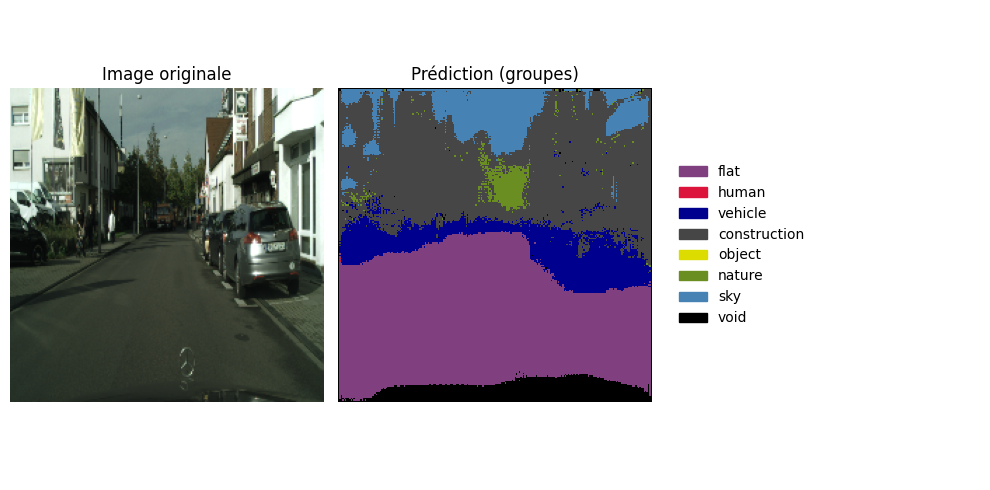

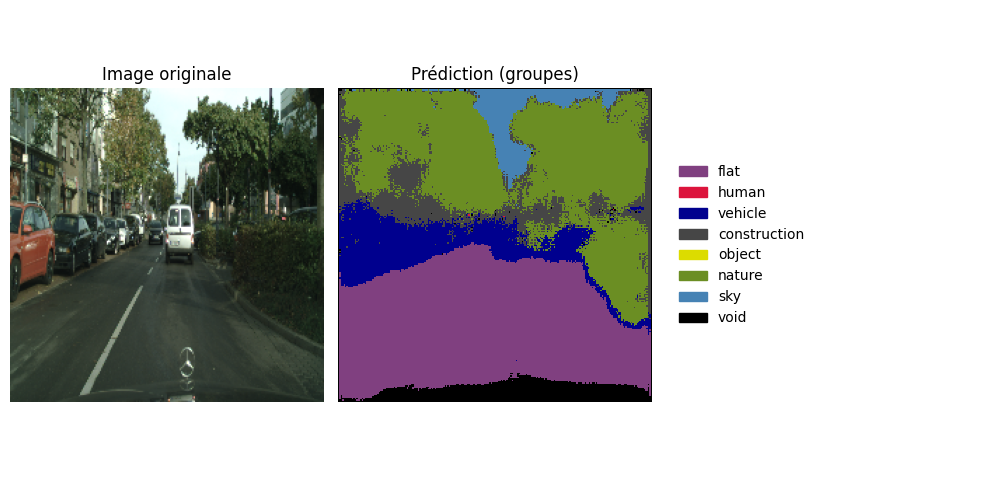

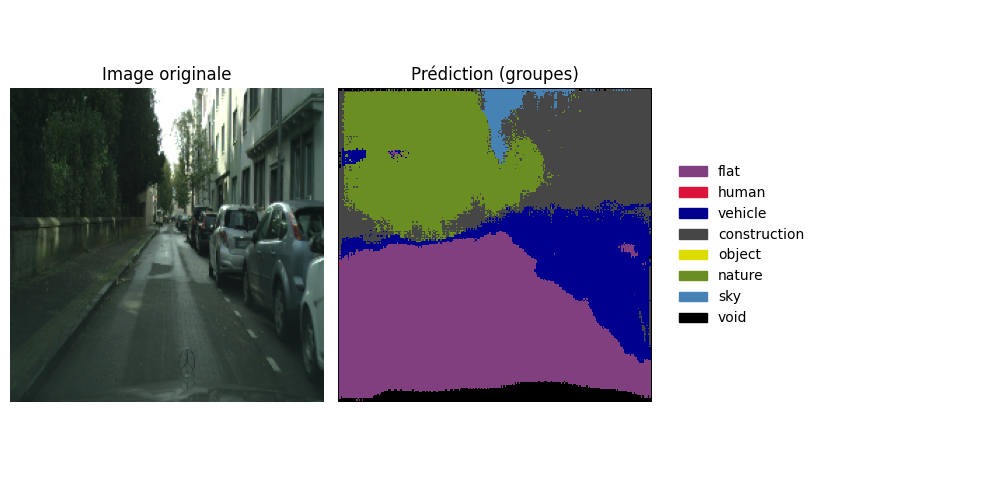

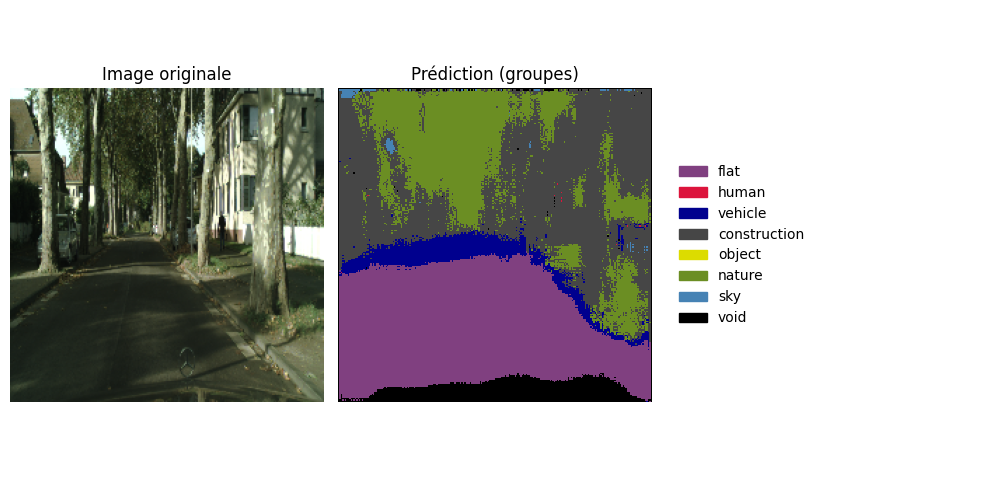

In [69]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = mini_unet_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

In [70]:
%%time
mlflow.set_experiment("mini_unet_model")

for x_batch, _ in test_ds.take(1):
    x_example = x_batch.numpy()
    break

with mlflow.start_run():
    mlflow.log_param("loss_type", "sparse_categorical_crossentropy")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("epochs", epochs)

    mlflow.log_metric("mean_val_accuracy", np.mean(hist_mini_unet.history["val_accuracy"]))
    mlflow.log_metric("mean_val_loss", np.mean(hist_mini_unet.history["val_loss"]))
    mlflow.log_metric("val_mean_io_u_argmax", np.mean(hist_mini_unet.history["val_mean_io_u_argmax"]))

    mini_unet_model_path = "mini_unet_model.keras"
    mini_unet_model.save(mini_unet_model_path)

    artifacts = {"mini_unet_model": mini_unet_model_path}

    mlflow.log_artifact(mini_unet_model_path, artifact_path="artifacts")

    signature = infer_signature(x_example, mini_unet_model.predict(x_example))

    mlflow.tensorflow.log_model(
        model=mini_unet_model,
        signature=signature,
        artifact_path="model",
        registered_model_name="mini_unet_model"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/07/31 21:33:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpagkpxeem/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'mini_unet_model' already exists. Creating a new version of this model...
2025/07/31 21:33:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mini_unet_model, version 8
Created version '8' of model 'mini_unet_model'.


🏃 View run efficient-zebra-44 at: https://mlflow.amadousy.dev/#/experiments/21/runs/613b4e0291134b5ab1e88b64f0cfd1a3
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/21
CPU times: user 4.84 s, sys: 199 ms, total: 5.03 s
Wall time: 24.8 s


## VGG16-UNet

In [71]:
vgg_model = create_model(model_type='vgg16_unet')
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 41,077,384 (156.70 MB)

 Trainable params: 41,069,448 (156.67 MB)

 Non-trainable params: 7,936 (31.00 KB)

Compile et entrainement

In [72]:
%%time
vgg_model = compile_model(vgg_model)
epochs = 30
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))
hist_vgg = vgg_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3630 - loss: 1.9083 - mean_io_u_argmax: 0.1491 - val_accuracy: 0.2356 - val_loss: 4.4183 - val_mean_io_u_argmax: 0.0712 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 754ms/step - accuracy: 0.6748 - loss: 1.0802 - mean_io_u_argmax: 0.3203 - val_accuracy: 0.2978 - val_loss: 2.2510 - val_mean_io_u_argmax: 0.1102 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 742ms/step - accuracy: 0.7176 - loss: 0.9409 - mean_io_u_argmax: 0.3692 - val_accuracy: 0.5451 - val_loss: 2.5293 - val_mean_io_u_argmax: 0.2393 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.7257 - loss: 0.8809 - mean_io_u_argmax: 0.3798 - val_accuracy: 0.7116 - val_loss: 1.5374 - val_mean_io_u_argmax: 0.3860 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 747ms/step - accuracy: 0.7309 - loss: 0.8543 - mean_io_u_argmax: 0.3828 - val_accuracy: 0.7823 - val

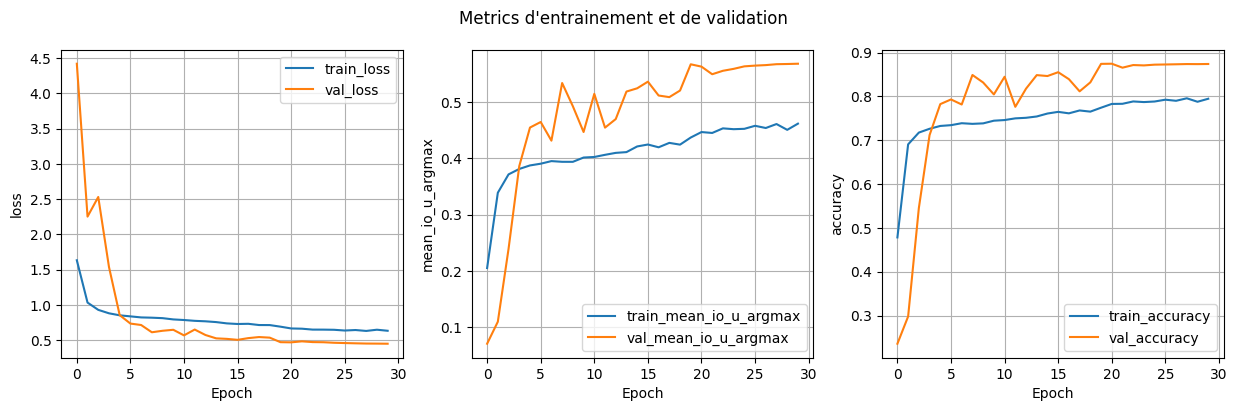

In [73]:
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


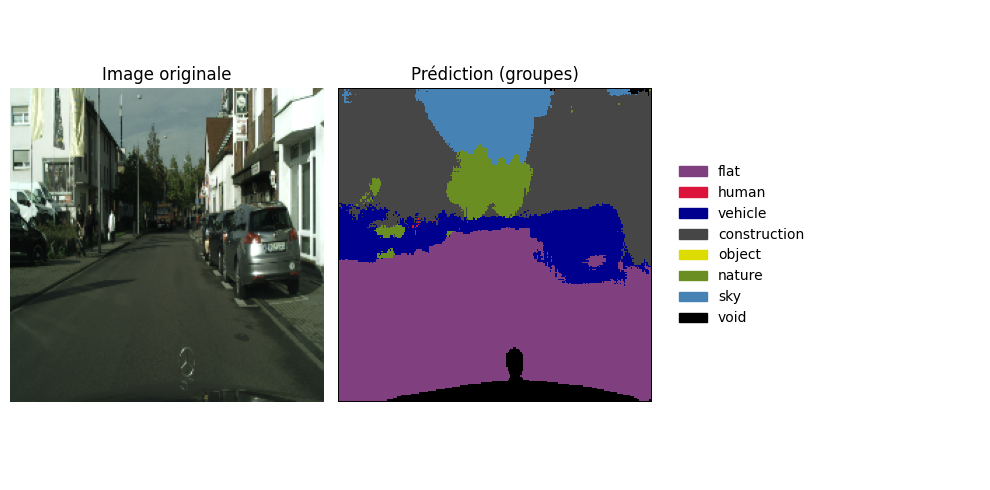

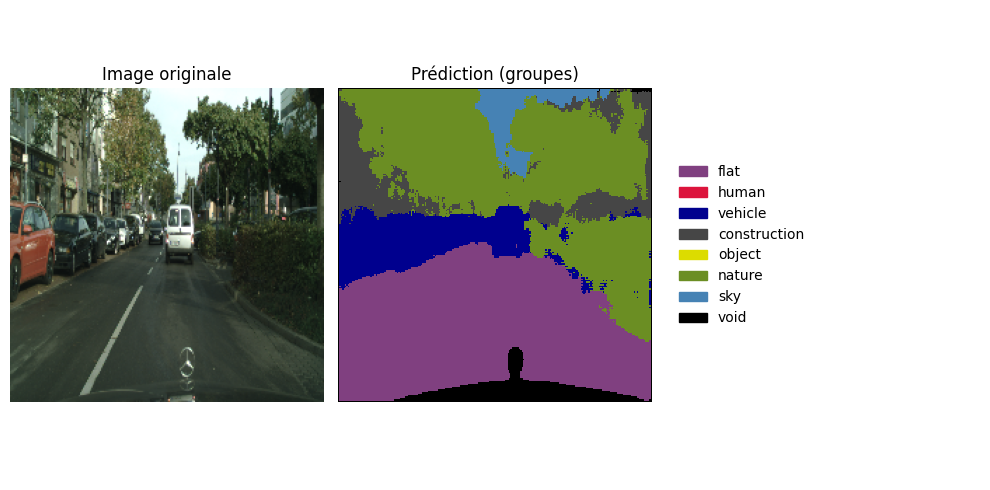

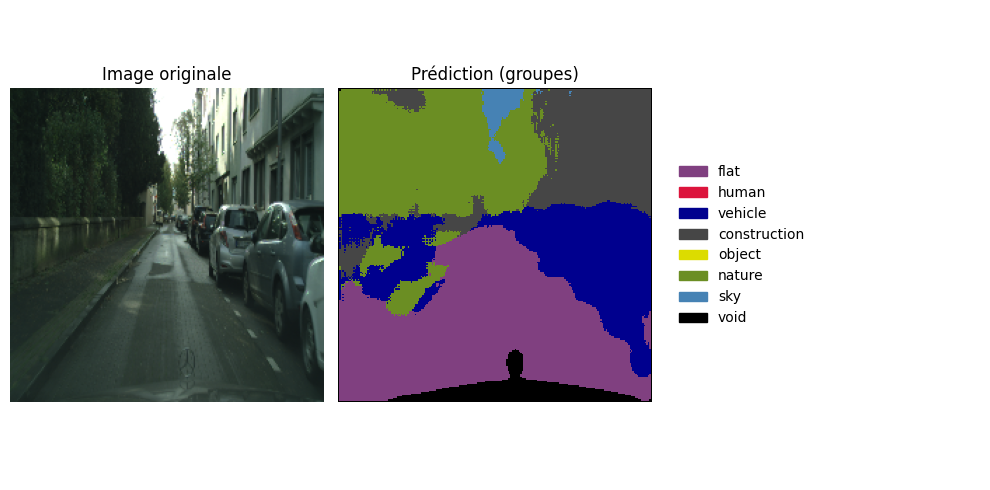

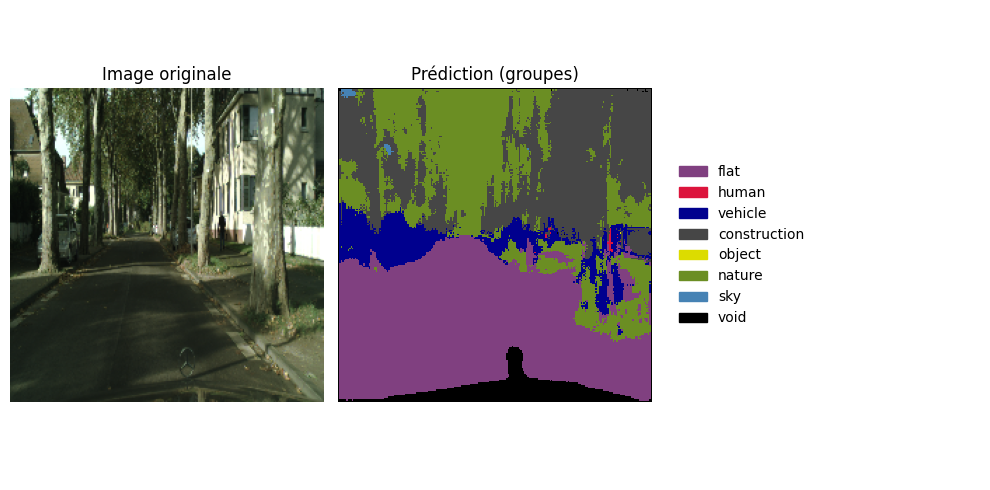

In [74]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = vgg_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

# Comparaison des modéls

## Performance

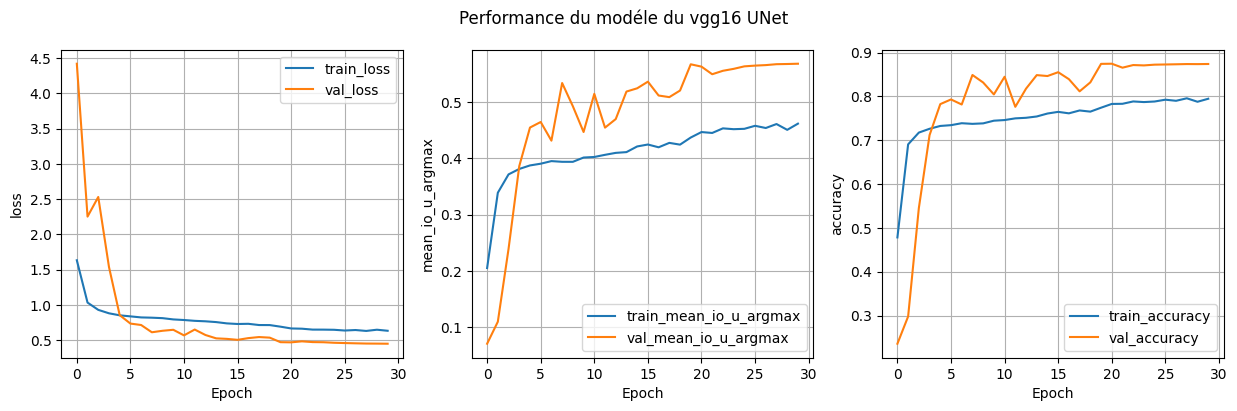

In [75]:
plot_training_history(history=hist_mini_unet, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle Mini UNet")
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modéle du vgg16 UNet")

In [76]:
import pandas as pd

df = pd.DataFrame({
    "Modèle": [
        "mini-U-Net",
        "VGG16-U-Net"
    ],
    "Val Loss final": [
        np.mean(hist_mini_unet.history['val_loss']),
        np.mean(hist_vgg.history['val_loss'])
    ],
    "Val Mean IoU (#8 classes)": [
        np.mean(hist_mini_unet.history['val_mean_io_u_argmax']),
        np.mean(hist_vgg.history['val_mean_io_u_argmax'])
    ],
    "Val Accuracy": [
        np.mean(hist_mini_unet.history['val_accuracy']),
        np.mean(hist_vgg.history['val_accuracy'])
    ],
    "Paramètres totaux": [
        mini_unet_model.count_params(),
        vgg_model.count_params()
    ],
    "Paramètres entraînables": [
        mini_unet_model.count_params(),
        vgg_model.count_params()
    ]
})

display(df)

Modèle  Val Loss final  Val Mean IoU (#8 classes)  Val Accuracy  \
0   mini-U-Net        1.202279                   0.333050      0.663045   
1  VGG16-U-Net        0.832302                   0.478924      0.789922   

   Paramètres totaux  Paramètres entraînables  
0            1931464                  1931464  
1           41077384                 41077384

**Loss de validation**
1.   Le VGG16-U-Net (0.69) réduit de plus de 50 % la loss par rapport au mini-U-Net (1.52).

2.   Un indicateur clair que ce backbone pré-entraîné apprend des représentations plus adaptées au jeu de Cityscapes.

**Mean IoU**
1.   Le VGG-U-Net atteint ≈ 0.50 contre ≈ 0.29 pour le mini-U-Net (+ 0.21 absolu, soit + 72 % relatif).

2.   C’est sur cette métrique clé de segmentation que l’écart est le plus marquant.

**Accuracy**
1.   Le VGG-U-Net frôle 0.81, tandis que le mini-U-Net plafonne à 0.62.
2.   Même si ce chiffre est pondéré par la dominance des classes majoritaires, la supériorité reste nette.

**Complexité du modèle**


1.   mini-U-Net : 1,93 M de paramètres, tous entraînables.
2.   VGG16-U-Net : 41,08 M de paramètres, tous entraînables.
3.   Le VGG-U-Net est ~ 21× plus volumineux, ce qui explique son coût mémoire et calcul supérieur.



## Conclusion

*   Le VGG16-U-Net offre une meilleure qualité de segmentation sur tous les indicateurs (loss, IoU, accuracy).


*   Le mini-U-Net est léger (≈ 2 M params) mais peine à généraliser (IoU < 0.30).

*   L’écart de performance se reflète directement dans la capacité à prédire correctement chaque classe pixel-par-pixel.

# Optimisation des hyperparametes

In [77]:
!pip install optuna optuna-integration -q
import optuna
from optuna.integration import TFKerasPruningCallback

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.3 MB/s eta 0:00:00


In [78]:
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))

In [79]:
def objective(trial):
    # Hyperparams à tuner
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    loss_type = trial.suggest_categorical("loss_type", ["cross_entropy", "dice_loss", "focal_loss", "balanced_cross_entropy"])


    model = create_model(model_type='vgg16_unet')
    model = compile_model(model, learning_rate=learning_rate, loss_type=loss_type)

    # Callback de pruning
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    history = model.fit(
        train_sample,
        validation_data=validation_sample,
        epochs=30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3),
            pruning_callback
        ]
    )

    return max(history.history["val_accuracy"])

In [80]:
%%time
study = optuna.create_study(study_name="vgg_unet_hyperparameter_optimization", direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-07-31 21:49:38,594] A new study created in memory with name: vgg_unet_hyperparameter_optimization


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 854ms/step - accuracy: 0.3716 - loss: 2.2253 - mean_io_u_argmax: 0.1443 - val_accuracy: 0.4479 - val_loss: 2.0616 - val_mean_io_u_argmax: 0.1146 - learning_rate: 3.6150e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 745ms/step - accuracy: 0.5749 - loss: 1.9036 - mean_io_u_argmax: 0.2381 - val_accuracy: 0.2151 - val_loss: 2.2483 - val_mean_io_u_argmax: 0.0950 - learning_rate: 3.6150e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.6405 - loss: 1.8575 - mean_io_u_argmax: 0.2822 - val_accuracy: 0.6444 - val_loss: 1.9238 - val_mean_io_u_argmax: 0.2569 - learning_rate: 3.6150e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.6532 - loss: 1.8339 - mean_io_u_argmax: 0.2967 - val_accuracy: 0.5751 - val_loss: 1.9309 - val_mean_io_u_argmax: 0.2501 - learning_rate: 3.6150e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.6560 - loss: 1.8253 - mean_io_u_argmax: 0.2969 - val_accuracy: 0.5663 - v

[I 2025-07-31 22:03:03,134] Trial 0 finished with value: 0.8449607491493225 and parameters: {'learning_rate': 0.0003614950807931604, 'loss_type': 'balanced_cross_entropy'}. Best is trial 0 with value: 0.8449607491493225.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 851ms/step - accuracy: 0.4397 - loss: 2.0700 - mean_io_u_argmax: 0.1612 - val_accuracy: 0.1870 - val_loss: 2.1712 - val_mean_io_u_argmax: 0.0256 - learning_rate: 0.0045
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.5341 - loss: 1.9172 - mean_io_u_argmax: 0.2108 - val_accuracy: 0.3201 - val_loss: 2.0998 - val_mean_io_u_argmax: 0.0976 - learning_rate: 0.0045
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 734ms/step - accuracy: 0.5669 - loss: 1.8896 - mean_io_u_argmax: 0.2352 - val_accuracy: 0.2133 - val_loss: 2.1406 - val_mean_io_u_argmax: 0.0474 - learning_rate: 0.0045
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 735ms/step - accuracy: 0.5771 - loss: 1.8782 - mean_io_u_argmax: 0.2442 - val_accuracy: 0.4061 - val_loss: 2.0884 - val_mean_io_u_argmax: 0.1416 - learning_rate: 0.0045
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.5683 - loss: 1.8788 - mean_io_u_argmax: 0.2336 - val_accuracy: 0.5033 - val_loss: 1.9534 

[I 2025-07-31 22:09:25,886] Trial 1 finished with value: 0.6673526167869568 and parameters: {'learning_rate': 0.004498305564951372, 'loss_type': 'balanced_cross_entropy'}. Best is trial 0 with value: 0.8449607491493225.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 866ms/step - accuracy: 0.5380 - loss: 1.4078 - mean_io_u_argmax: 0.2122 - val_accuracy: 0.4052 - val_loss: 60.6934 - val_mean_io_u_argmax: 0.1261 - learning_rate: 5.6114e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 754ms/step - accuracy: 0.6927 - loss: 0.9074 - mean_io_u_argmax: 0.3466 - val_accuracy: 0.0831 - val_loss: 359.0699 - val_mean_io_u_argmax: 0.0104 - learning_rate: 5.6114e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.7134 - loss: 0.8618 - mean_io_u_argmax: 0.3678 - val_accuracy: 0.1667 - val_loss: 33.6860 - val_mean_io_u_argmax: 0.0601 - learning_rate: 5.6114e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 742ms/step - accuracy: 0.7209 - loss: 0.8419 - mean_io_u_argmax: 0.3737 - val_accuracy: 0.2798 - val_loss: 8.0782 - val_mean_io_u_argmax: 0.1153 - learning_rate: 5.6114e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 744ms/step - accuracy: 0.7202 - loss: 0.8321 - mean_io_u_argmax: 0.3730 - val_accuracy: 0.4301

[I 2025-07-31 22:23:47,163] Trial 2 finished with value: 0.8704782128334045 and parameters: {'learning_rate': 0.0005611426851590155, 'loss_type': 'cross_entropy'}. Best is trial 2 with value: 0.8704782128334045.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 863ms/step - accuracy: 0.5060 - loss: 0.3161 - mean_io_u_argmax: 0.2105 - val_accuracy: 0.2046 - val_loss: 0.3966 - val_mean_io_u_argmax: 0.0441 - learning_rate: 0.0014
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 750ms/step - accuracy: 0.6785 - loss: 0.2602 - mean_io_u_argmax: 0.3310 - val_accuracy: 0.5078 - val_loss: 0.3087 - val_mean_io_u_argmax: 0.1615 - learning_rate: 0.0014
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 744ms/step - accuracy: 0.7012 - loss: 0.2527 - mean_io_u_argmax: 0.3531 - val_accuracy: 0.3797 - val_loss: 0.3442 - val_mean_io_u_argmax: 0.2141 - learning_rate: 0.0014
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 740ms/step - accuracy: 0.7109 - loss: 0.2495 - mean_io_u_argmax: 0.3648 - val_accuracy: 0.2230 - val_loss: 0.3908 - val_mean_io_u_argmax: 0.0863 - learning_rate: 0.0014
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.7132 - loss: 0.2488 - mean_io_u_argmax: 0.3655 - val_accuracy: 0.3884 - val_loss: 0.3428 

[I 2025-07-31 22:38:07,295] Trial 3 finished with value: 0.8686582446098328 and parameters: {'learning_rate': 0.0013713473730269585, 'loss_type': 'focal_loss'}. Best is trial 2 with value: 0.8704782128334045.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 857ms/step - accuracy: 0.2893 - loss: 2.0270 - mean_io_u_argmax: 0.1308 - val_accuracy: 0.2188 - val_loss: 3.4075 - val_mean_io_u_argmax: 0.0503 - learning_rate: 1.6214e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - accuracy: 0.6783 - loss: 1.0587 - mean_io_u_argmax: 0.3266 - val_accuracy: 0.2016 - val_loss: 34.0614 - val_mean_io_u_argmax: 0.0814 - learning_rate: 1.6214e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 740ms/step - accuracy: 0.7071 - loss: 0.9515 - mean_io_u_argmax: 0.3610 - val_accuracy: 0.5234 - val_loss: 4.0584 - val_mean_io_u_argmax: 0.2349 - learning_rate: 1.6214e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.7200 - loss: 0.8975 - mean_io_u_argmax: 0.3745 - val_accuracy: 0.3821 - val_loss: 13.6927 - val_mean_io_u_argmax: 0.2536 - learning_rate: 1.6214e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - accuracy: 0.7196 - loss: 0.8819 - mean_io_u_argmax: 0.3781 - val_accuracy: 0.5907 -

[I 2025-07-31 22:52:30,187] Trial 4 finished with value: 0.8696351051330566 and parameters: {'learning_rate': 0.00016214254764782208, 'loss_type': 'cross_entropy'}. Best is trial 2 with value: 0.8704782128334045.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 830ms/step - accuracy: 0.4680 - loss: 1.5845 - mean_io_u_argmax: 0.1827 - val_accuracy: 0.5283 - val_loss: 17.8137 - val_mean_io_u_argmax: 0.1472 - learning_rate: 3.1956e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 753ms/step - accuracy: 0.6830 - loss: 0.9538 - mean_io_u_argmax: 0.3321 - val_accuracy: 0.4941 - val_loss: 4.0994 - val_mean_io_u_argmax: 0.1608 - learning_rate: 3.1956e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 744ms/step - accuracy: 0.7085 - loss: 0.8838 - mean_io_u_argmax: 0.3609 - val_accuracy: 0.5505 - val_loss: 2.3765 - val_mean_io_u_argmax: 0.2414 - learning_rate: 3.1956e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.7140 - loss: 0.8612 - mean_io_u_argmax: 0.3671 - val_accuracy: 0.5674 - val_loss: 1.6376 - val_mean_io_u_argmax: 0.2405 - learning_rate: 3.1956e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 747ms/step - accuracy: 0.7197 - loss: 0.8446 - mean_io_u_argmax: 0.3727 - val_accuracy: 0.6444 - 

[I 2025-07-31 22:55:41,668] Trial 5 pruned. Trial was pruned at epoch 5.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4946 - loss: 0.8659 - mean_io_u_argmax: 0.2070

[I 2025-07-31 22:56:31,944] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.3152 - loss: 0.8854 - mean_io_u_argmax: 0.1424

[I 2025-07-31 22:57:21,030] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.5011 - loss: 0.3110 - mean_io_u_argmax: 0.2012

[I 2025-07-31 22:58:12,172] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4344 - loss: 0.3458 - mean_io_u_argmax: 0.1763

[I 2025-07-31 22:59:02,011] Trial 9 pruned. Trial was pruned at epoch 0.


CPU times: user 5h 37min 4s, sys: 7min 37s, total: 5h 44min 41s
Wall time: 1h 9min 23s


In [81]:
print("Best hyperparameters:")
print(study.best_params)

print("Best validation accuracy:", study.best_value)

Best hyperparameters:
{'learning_rate': 0.0005611426851590155, 'loss_type': 'cross_entropy'}
Best validation accuracy: 0.8704782128334045


In [82]:
optuna.visualization.plot_slice(study,target_name="Accuracy")

In [83]:
optuna.visualization.plot_rank(study)

Entrainement du modéle final

In [84]:
final_model = create_model(model_type='vgg16_unet')
final_model = compile_model(
    final_model,
    learning_rate=study.best_params["learning_rate"],
    loss_type=study.best_params["loss_type"],
    metrics=['accuracy', MeanIoUArgmax(num_classes=8)]
)
final_model.summary()

Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_16[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 41,077,384 (156.70 MB)

 Trainable params: 41,069,448 (156.67 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [85]:
history = final_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
    ]
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.5912 - loss: 1.2645 - mean_io_u_argmax: 0.2707 - val_accuracy: 0.3171 - val_loss: 13.4315 - val_mean_io_u_argmax: 0.1502 - learning_rate: 5.6114e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 739ms/step - accuracy: 0.7179 - loss: 0.8503 - mean_io_u_argmax: 0.3711 - val_accuracy: 0.3549 - val_loss: 4.3266 - val_mean_io_u_argmax: 0.1616 - learning_rate: 5.6114e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.7289 - loss: 0.8206 - mean_io_u_argmax: 0.3822 - val_accuracy: 0.3809 - val_loss: 1.6794 - val_mean_io_u_argmax: 0.1659 - learning_rate: 5.6114e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 735ms/step - accuracy: 0.7332 - loss: 0.8035 - mean_io_u_argmax: 0.3873 - val_accuracy: 0.6245 - val_loss: 1.5546 - val_mean_io_u_argmax: 0.3112 - learning_rate: 5.6114e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.7389 - loss: 0.7868 - mean_io_u_argmax: 0.3957 - val_accuracy: 0.7551 - va

Visualisation des performances

In [86]:
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance avant optimisation")
plot_training_history(history=history, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle final")

Tests de prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


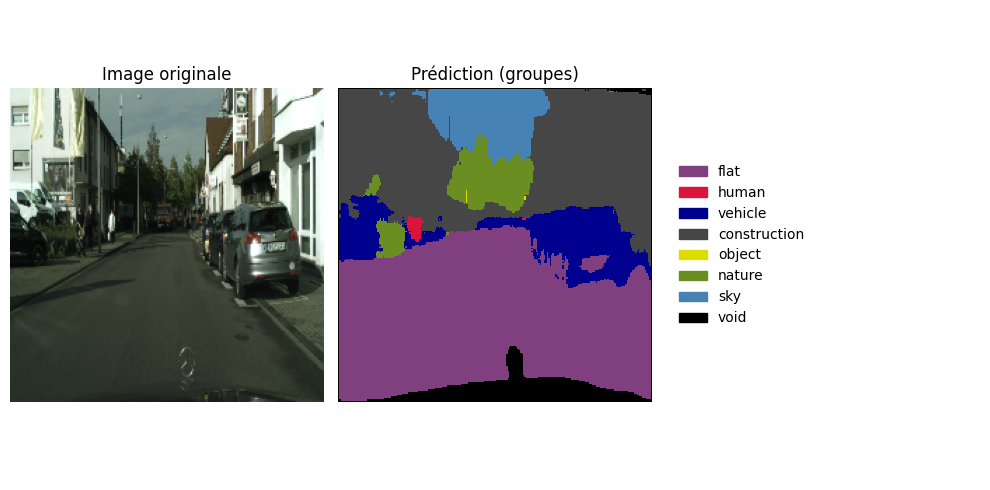

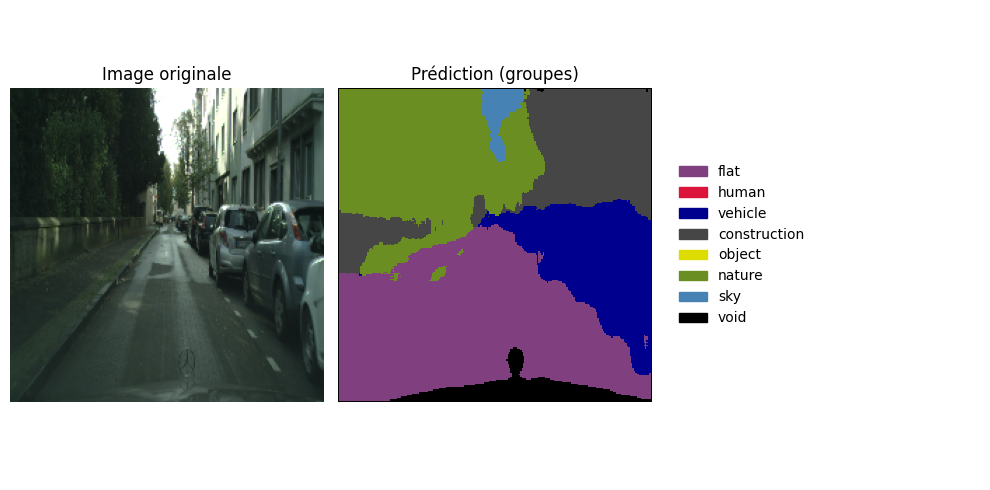

In [87]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = final_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

In [88]:
# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [89]:
%%time
MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("vgg16_unet_model")

for x_batch, _ in test_ds.take(1):
    x_example = x_batch.numpy()
    break

with mlflow.start_run():
    mlflow.log_param("learning_rate", study.best_params["learning_rate"])
    mlflow.log_param("loss_type", study.best_params["loss_type"])
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("epochs", 30)

    mlflow.log_metric("mean_val_accuracy", np.mean(history.history["val_accuracy"]))
    mlflow.log_metric("mean_val_loss", np.mean(history.history["val_loss"]))
    mlflow.log_metric("val_mean_io_u_argmax", np.mean(history.history["val_mean_io_u_argmax"]))

    vgg16_unet_model_path = "vgg16_unet_model.keras"
    final_model.save(vgg16_unet_model_path)

    artifacts = {"vgg16_unet_model": vgg16_unet_model_path}

    mlflow.log_artifact(vgg16_unet_model_path, artifact_path="artifacts")

    signature = infer_signature(x_example, final_model.predict(x_example))

    mlflow.tensorflow.log_model(
        model=final_model,
        signature=signature,
        artifact_path="model",
        registered_model_name="vgg16_unet_model"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


2025/07/31 23:40:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt2nflf69/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'vgg16_unet_model' already exists. Creating a new version of this model...
2025/07/31 23:41:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vgg16_unet_model, version 4
Created version '4' of model 'vgg16_unet_model'.


🏃 View run amusing-vole-822 at: https://mlflow.amadousy.dev/#/experiments/20/runs/103d9f9f3d51407cba461f520db67fb5
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/20
CPU times: user 7.63 s, sys: 2.53 s, total: 10.2 s
Wall time: 2min 7s


In [90]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=8157.795439243317 seconds
